# Семинар 1

В рамках данного задания мы расммотрим несколько возможных сценариев как можно использовать предобученную языковую модель и как модифицировать ее для улучшения ваших метрик

Но для начала изучим частую используемую операцию и заметно сокращающую записи - это операцию EINSUM

In [10]:
import os
import sys

from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import torch
from transformers import AutoModel, AutoTokenizer

## Вводный блок

## Тренировка модели BERT

Скачаем тренировочный датасет, для multilabel-классификации ненормативных комментариев на 4 класса.

In [1]:
!wget https://raw.githubusercontent.com/snv-ds/NLP_course/master/week2/train

--2024-02-09 00:15:02--  https://raw.githubusercontent.com/snv-ds/NLP_course/master/week2/train
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24525472 (23M) [text/plain]
Saving to: ‘train’

train               100%[===================>]  23,39M  39,9MB/s    in 0,6s    

2024-02-09 00:15:04 (39,9 MB/s) - ‘train’ saved [24525472/24525472]



In [4]:
!ls

baselines	      README.md			       seminar_2.ipynb
data		      requirements.txt		       seminar_6_solved.ipynb
evaluation	      ru_detoxification_evaluation.py  train
__pycache__	      ru_detoxification_metrics.py
README_evaluation.md  seminar_1.ipynb


In [2]:
parse_labels = ['__label__NORMAL','__label__INSULT','__label__THREAT','__label__OBSCENITY']

In [5]:
train = pd.read_csv('train', sep='\t', names=['id','target','temp1','temp2','comment'], index_col=0)

mask = train['comment'].isin(parse_labels) # to cope only with correct rows in data

train.loc[mask,'target'] = train[mask]['target'] + ',' + train[mask]['comment']
train.loc[mask,'comment'] = np.nan

for t in ['temp1','temp2']: # if comment have several labels of classes
    mask = train[t].isin(parse_labels)
    train.loc[mask,'target'] = train[mask]['target'] + ',' + train[mask][t]
    train.loc[mask,t] = np.nan
    train.loc[~train[t].isna(),'comment'] = train[~train[t].isna()][t]

train[['оскорбление','другое','непростойность','угроза']] = train['target'].str.get_dummies(sep=',')

train = train[['другое','оскорбление','непростойность','угроза', 'comment']]
train.sample(7)

,другое,оскорбление,непростойность,угроза,comment
id,,,,,
117082,1,0,0,0,есть такое . есть
11298,0,1,0,1,"теперь понятно почему рыба не клюёт, после так..."
113653,0,1,0,1,стрелять стрелять и еще раз стрелять !!!! мы ж...
140621,1,0,0,0,всем доброго вечера.. у нас сегодня дождь с жу...
52572,1,0,0,0,"всё верно говорит,таких людей много на украине..."
243426,1,0,0,0,красавица и талантище- таких больше нет
192888,1,0,0,0,музыка окутывает и укутывает в нежностью и таи...


Ограничим датасет для ускорения тренировки

In [6]:
train = train.sample(70000)

## Использование BERT как feature extractor

In [14]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")
model.cuda()

tokenizer_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/468k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(29564, 312, padding_idx=0)
    (position_embeddings): Embedding(512, 312)
    (token_type_embeddings): Embedding(2, 312)
    (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-2): 3 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=312, out_features=312, bias=True)
            (key): Linear(in_features=312, out_features=312, bias=True)
            (value): Linear(in_features=312, out_features=312, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=312, out_features=312, bias=True)
            (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
    

In [7]:
texts = train.comment

In [8]:
x = np.zeros((len(texts), 312))
y = np.array(train[['другое',	'оскорбление',	'непростойность',	'угроза']])

In [15]:
def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt') # use padding, truncation of long sequences and return pytorch tensors
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()}) # move all tensors on the same device as model
    embeddings = model_output.last_hidden_state[:, 0, :] # use only first [CLS] token vector
    embeddings = torch.nn.functional.normalize(embeddings) # normalize vector for easier convergence
    return embeddings[0].cpu().numpy() # return result as numpy vector

In [16]:
for ind, sent in enumerate(tqdm(texts)):
  x[ind] = embed_bert_cls(sent, model, tokenizer)

  0%|          | 0/70000 [00:00<?, ?it/s]

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=2029)

In [19]:
y_train.shape, x_train.shape

((52500, 4), (52500, 312))

In [20]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

Можете обучить любую модель классификации, которая вам по душе

In [21]:
simple_model = OneVsRestClassifier(estimator=LogisticRegression(random_state=2029, solver='sag', C=50)).fit(x_train, y_train)
y_pred = simple_model.predict(x_test)

In [23]:
print(classification_report(y_pred, y_test, target_names=['другое', 'оскорбление', 'непростойность', 'угроза'], zero_division=False))

                precision    recall  f1-score   support

        другое       0.96      0.90      0.93     15287
   оскорбление       0.45      0.70      0.55      1665
непростойность       0.10      0.57      0.17        49
        угроза       0.43      0.76      0.55       489

     micro avg       0.85      0.87      0.86     17490
     macro avg       0.48      0.73      0.55     17490
  weighted avg       0.89      0.87      0.88     17490
   samples avg       0.86      0.86      0.86     17490



## Используем BERT как эмбеддер 

Посчитаем общее количество параметров, которое есть в модели

В рамках каждой части мы будем инициализирвать датасет каждый раз, для возможности воспроизведения каждого блока

In [27]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel

In [29]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")

In [30]:
sum(param.numel() for param in model.parameters())

11784168

In [31]:
train = pd.read_csv('train', sep='\t', names=['id','target','temp1','temp2','comment'], index_col=0)

mask = train['comment'].isin(parse_labels) # to cope only with correct rows in data

train.loc[mask,'target'] = train[mask]['target'] + ',' + train[mask]['comment']
train.loc[mask,'comment'] = np.nan

for t in ['temp1','temp2']: # if comment have several labels of classes
    mask = train[t].isin(parse_labels)
    train.loc[mask,'target'] = train[mask]['target'] + ',' + train[mask][t]
    train.loc[mask,t] = np.nan
    train.loc[~train[t].isna(),'comment'] = train[~train[t].isna()][t]

train[['оскорбление','другое','непростойность','угроза']] = train['target'].str.get_dummies(sep=',')

train = train[['другое','оскорбление','непростойность','угроза', 'comment']]
train.sample(2)

,другое,оскорбление,непростойность,угроза,comment
id,,,,,
68512,1,0,0,0,у вас доставка есть и фото можно личку
76623,1,0,0,0,получается у нас один диагноз подходит а по не...


In [32]:
train_text, val_text, train_labels, val_labels = train_test_split(train.comment,
                                                              train[['другое','оскорбление',
                                                                     'непростойность','угроза']],
                                                              test_size = 0.2,
                                                              random_state=2029)

In [33]:
text = train_text[:2].tolist()
# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True)
# output
sent_id.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

Заметим, что  комментарии не такие длинные, поэтому в этом задании BERT может показать отличные результаты.

<Axes: >

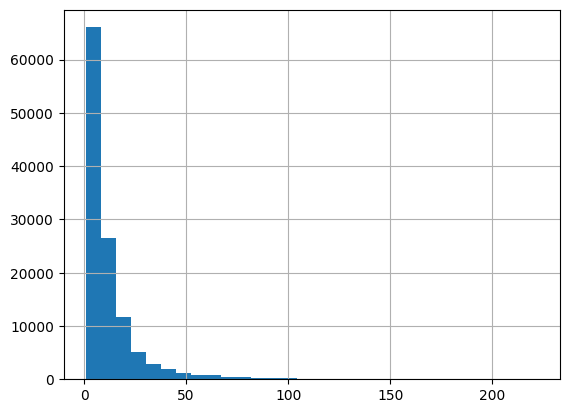

In [34]:
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 30)

Посмотрим на высокий перцентиль, чтобы им ограничить наш сет

In [36]:
pd.Series(seq_len).quantile(0.965)

49.0

In [37]:
tokens_train = tokenizer.batch_encode_plus(
train_text.tolist(),
max_length = 50,
padding='max_length',
truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
val_text.tolist(),
max_length = 50,
padding='max_length',
truncation=True
)

In [38]:
## convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.values.tolist(), dtype=torch.float)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.values.tolist(), dtype=torch.float)

In [39]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data,
                              sampler=train_sampler,
                              batch_size=batch_size)
# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data,
                            sampler = val_sampler,
                            batch_size=batch_size)

Попробуем заморозить все параметры параметры BERT`а

In [41]:
for param in model.parameters():
  param.requires_grad = False

In [42]:
class BERT_Arch(nn.Module):

    def __init__(self, bert, n_output):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      self.dropout = nn.Dropout(0.1)

      self.relu =  nn.ReLU()
      # dense layer 1
      self.fc1 = nn.Linear(312, 128)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(128, n_output)

    #define the forward pass
    def forward(self, input_ids, attention_mask):

      #pass the inputs to the model  
      bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
      last_hidden_state = bert_output.last_hidden_state[:, 0, :]

      x = self.fc1(last_hidden_state)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      return x

In [43]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_embeder = BERT_Arch(model, n_output=4).to(device)

Пересчитаем количество обучаемых параметров в модели

In [45]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

0

In [50]:
from torch.optim import AdamW

optimizer = AdamW(model_embeder.parameters(), lr = 1e-5)

In [51]:
cross_entropy = torch.nn.functional.binary_cross_entropy_with_logits

# number of training epochs
epochs = 5

In [52]:
batch = iter(train_dataloader).__next__()

text, mask, label = batch
pred = model_embeder(text.to(device), mask.to(device))

cross_entropy(pred.cpu(), label)

tensor(0.7197, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [71]:
def train(model):
  model.train()

  total_loss = 0
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step, batch in enumerate(tqdm(train_dataloader)):

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # append the model predictions
    total_preds.append(preds.detach().cpu().numpy())

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return (avg_loss, total_preds), model

In [72]:
def evaluate(model):
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss = 0
  
  # empty list to save the model predictions
  total_preds, total_labels = [], []
  
  # iterate over batches
  for step,batch in enumerate(tqdm(val_dataloader)):

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      total_preds.append(preds.detach().cpu().numpy())
      total_labels.append(labels.detach().cpu().numpy())

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  total_labels  = np.concatenate(total_labels, axis=0)
  
  # print evaluation metrics for our model
  print(classification_report(total_labels,
                              torch.sigmoid(torch.tensor(total_preds)).round(),
                              zero_division=True))

  return (avg_loss, total_preds),  model

In [73]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    (train_loss, _), model_embeder = train(model_embeder)
    
    #evaluate model
    (valid_loss, _), model_embeder = evaluate(model_embeder)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_embeder.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5


  0%|          | 0/3720 [00:00<?, ?it/s]


Evaluating...


  0%|          | 0/930 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.89      0.96      0.92     24352
           1       0.71      0.38      0.49      4458
           2       0.82      0.04      0.07       470
           3       0.76      0.40      0.52      1507

   micro avg       0.87      0.83      0.85     30787
   macro avg       0.79      0.44      0.50     30787
weighted avg       0.86      0.83      0.83     30787
 samples avg       0.88      0.85      0.85     30787


Training Loss: 0.195
Validation Loss: 0.186

 Epoch 2 / 5


  0%|          | 0/3720 [00:00<?, ?it/s]


Evaluating...


  0%|          | 0/930 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.89      0.96      0.92     24352
           1       0.71      0.38      0.49      4458
           2       0.82      0.04      0.07       470
           3       0.76      0.40      0.52      1507

   micro avg       0.87      0.83      0.85     30787
   macro avg       0.79      0.44      0.50     30787
weighted avg       0.86      0.83      0.83     30787
 samples avg       0.88      0.85      0.85     30787


Training Loss: 0.195
Validation Loss: 0.186

 Epoch 3 / 5


  0%|          | 0/3720 [00:00<?, ?it/s]


Evaluating...


  0%|          | 0/930 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.89      0.96      0.92     24352
           1       0.71      0.38      0.49      4458
           2       0.82      0.04      0.07       470
           3       0.76      0.40      0.52      1507

   micro avg       0.87      0.83      0.85     30787
   macro avg       0.79      0.44      0.50     30787
weighted avg       0.86      0.83      0.83     30787
 samples avg       0.88      0.85      0.85     30787


Training Loss: 0.195
Validation Loss: 0.186

 Epoch 4 / 5


  0%|          | 0/3720 [00:00<?, ?it/s]


Evaluating...


  0%|          | 0/930 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.89      0.96      0.92     24352
           1       0.71      0.38      0.49      4458
           2       0.82      0.04      0.07       470
           3       0.76      0.40      0.52      1507

   micro avg       0.87      0.83      0.85     30787
   macro avg       0.79      0.44      0.50     30787
weighted avg       0.86      0.83      0.83     30787
 samples avg       0.88      0.85      0.85     30787


Training Loss: 0.195
Validation Loss: 0.186

 Epoch 5 / 5


  0%|          | 0/3720 [00:00<?, ?it/s]


Evaluating...


  0%|          | 0/930 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.89      0.96      0.92     24352
           1       0.71      0.38      0.49      4458
           2       0.82      0.04      0.07       470
           3       0.76      0.40      0.52      1507

   micro avg       0.87      0.83      0.85     30787
   macro avg       0.79      0.44      0.50     30787
weighted avg       0.86      0.83      0.83     30787
 samples avg       0.88      0.85      0.85     30787


Training Loss: 0.195
Validation Loss: 0.186


Попробуем более сложную архитектуру, использовав более продвинутый слой поверх BERT'а, например попробуйте GRU поверх BERT'а.

Не забывайте, что RNN работает с последовательностями и он ожидает вектор для каждого токена, которые были получены из эмбеддингов BERT.

In [70]:
class BERT_Arch(nn.Module):

    def __init__(self, bert, n_output):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      self.dropout = nn.Dropout(0.1)

      self.rnn = nn.GRU(312,
                        256,
                        num_layers=2,
                        batch_first=True,
                        dropout=0.1)
        
      self.out = nn.Linear(256, n_output)
        
    #define the forward pass
    def forward(self, input_ids, attention_mask):

      #pass the inputs to the model  
      bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
      last_hidden_state = bert_output.last_hidden_state

      _, hidden = self.rnn(last_hidden_state)
        
      #hidden = [n layers * n directions, batch size, emb dim]
        
      hidden = self.dropout(hidden[-1,:,:])
                
      #hidden = [batch size, hid dim]
        
      output = self.out(hidden)
        
      #output = [batch size, out dim]
        
      return output

In [67]:
model_gru = BERT_Arch(model, 4).to(device)
optimizer = AdamW(model_gru.parameters(), lr = 1e-5)

Подсчитайте количество параметров, которое мы обучаем, и общее количество параметров.

In [68]:
batch = iter(train_dataloader).__next__()

text, mask, label = batch
pred = model_gru(text.to(device), mask.to(device))
# pred
cross_entropy(pred.cpu(), label)

tensor(0.6820, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

Обучая GRU можете заметить, что она обучается медленнее, но получим лучшее качество

In [75]:
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    (train_loss, _), model_gru = train(model_gru)
    
    #evaluate model
    (valid_loss, _), model_gru = evaluate(model_gru)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_gru.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5


  0%|          | 0/3720 [00:00<?, ?it/s]


Evaluating...


  0%|          | 0/930 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     24352
           1       0.64      0.40      0.50      4458
           2       1.00      0.00      0.00       470
           3       0.82      0.03      0.06      1507

   micro avg       0.87      0.81      0.84     30787
   macro avg       0.84      0.35      0.37     30787
weighted avg       0.85      0.81      0.80     30787
 samples avg       0.87      0.83      0.83     30787


Training Loss: 0.313
Validation Loss: 0.204

 Epoch 2 / 5


  0%|          | 0/3720 [00:00<?, ?it/s]


Evaluating...


  0%|          | 0/930 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.90      0.95      0.93     24352
           1       0.71      0.48      0.57      4458
           2       0.50      0.00      0.00       470
           3       0.67      0.38      0.48      1507

   micro avg       0.88      0.84      0.86     30787
   macro avg       0.69      0.45      0.50     30787
weighted avg       0.86      0.84      0.84     30787
 samples avg       0.89      0.85      0.85     30787


Training Loss: 0.204
Validation Loss: 0.184

 Epoch 3 / 5


  0%|          | 0/3720 [00:00<?, ?it/s]


Evaluating...


  0%|          | 0/930 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     24352
           1       0.66      0.62      0.64      4458
           2       0.26      0.02      0.03       470
           3       0.71      0.41      0.52      1507

   micro avg       0.88      0.85      0.86     30787
   macro avg       0.64      0.50      0.53     30787
weighted avg       0.87      0.85      0.85     30787
 samples avg       0.89      0.86      0.86     30787


Training Loss: 0.190
Validation Loss: 0.176

 Epoch 4 / 5


  0%|          | 0/3720 [00:00<?, ?it/s]


Evaluating...


  0%|          | 0/930 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.91      0.97      0.94     24352
           1       0.79      0.53      0.63      4458
           2       0.33      0.01      0.02       470
           3       0.73      0.46      0.56      1507

   micro avg       0.89      0.87      0.88     30787
   macro avg       0.69      0.49      0.54     30787
weighted avg       0.88      0.87      0.86     30787
 samples avg       0.90      0.88      0.88     30787


Training Loss: 0.178
Validation Loss: 0.162

 Epoch 5 / 5


  0%|          | 0/3720 [00:00<?, ?it/s]


Evaluating...


  0%|          | 0/930 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.93      0.96      0.94     24352
           1       0.76      0.62      0.69      4458
           2       0.36      0.03      0.05       470
           3       0.72      0.51      0.60      1507

   micro avg       0.90      0.87      0.89     30787
   macro avg       0.69      0.53      0.57     30787
weighted avg       0.89      0.87      0.88     30787
 samples avg       0.91      0.88      0.88     30787


Training Loss: 0.168
Validation Loss: 0.152


### Что можно улучшить самостоятельно

Вы можете добавить:

1. предварительную обработку текста
2. увеличение тренировочного корпуса
3. попробуйте более продвинутые слои поверх BERT (будьте осторожны, не переобучиться на train)
4. используйте ансамбль моделей

## Часть 2

После изучения основных методов дообучения BERT, давайте рассмотрим как можно расширить контекст BERT-like модели

Существует модель [LongFormer](https://arxiv.org/abs/2004.05150), которая достаточно эффективно решает задачу увеличения контекста модели.

В ней используется разделение внимания на локальное и глобальное, у каждого свои весовые матрицы. Для глобального self-attention выбирается фиксированный набор токенов (могут быть важные, типа CLS или токенов вопроса для QA), на эти токены могут смотреть все остальные токены, и эти токены могут взаимодействовать со всеми остальными.

В локальном внимании токен может смотреть на N токенов вокруг себя, от слоя к слою захватывая всё более длинные зависимости. При этом N токенов могут быть как ближайшими к текущему обрабатываемому, так и идти с заданным шагом (Dilated Sliding Window, допустимо на верхних слоях). Разные головы self-attention могут иметь шаблоны внимания.

![](./images/longformer.png)

Скорее всего вам никогда не придется дообучать модель для поддержки более длинного контекста, однако для понимая принципов будет не лишним разобрать как это можно сделать. Мы с вами рассмотрим часть ноутбука коллеги, который обучал модели ru-longformer-tiny-16384 и другие ее аналоги

In [ ]:
import torch
from transformers import BertConfig, BertForMaskedLM, BertTokenizerFast, LongformerConfig, LongformerForMaskedLM

В качестве базовой модели автор брал модель RoBERTa обученную на русском языке. Описанные далее подход позволяет использовать проверенную архитектуру модели, расширяя ее возможности для обработки более длинных документов или последовательностей текста, что особенно полезно в таких задачах как классификация документов, QA и других задачах, требующих глубокого понимания контекста.

Longformer создается из роберты и можно сделать версии base и large. Однако эти модели будут не очень применимы на практике в силу своего внушительного размера (large-версия занимала порядка 38Gb видеопамяти обучаясь на векторах в 4096 токенов длиной, обучение base в fp16 займет порядка 16Gb карточку).

Вся реализация далее основывается на оригинальной [статье](https://arxiv.org/abs/2004.05150) и [ноутбуке](https://github.com/allenai/longformer/blob/master/scripts/convert_model_to_long.ipynb) от коллег из allenai, проделавших нечто похожее для модели RoBERTa

Настройка конфигурации Longformer:

Класс LongformerConfig используется для создания новой конфигурации для модели Longformer. Эта конфигурация тесно повторяет архитектуру модели RoBERT, но включает в себя корректировки для специфических особенностей Longformer. Параметры, такие как vocab_size, hidden_size, num_hidden_layers, num_attention_heads, intermediate_size, attention_probs_dropout_prob, hidden_dropout_prob и initializer_range, копируются напрямую из конфигурации RoBERT, чтобы обеспечить соответствие базовой архитектуры Longformer архитектуре RoBERTa.
max_position_embeddings=16386 явно устанавливается для определения максимальной длины последовательности, которую может обрабатывать Longformer. Это значительно больше, чем у стандартных моделей RoBERTa, позволяя Longformer обрабатывать гораздо более длинные последовательности.  

Инициализация модели Longformer для MLM: LongformerForMaskedLM(longformer_config) инициализирует модель Longformer с указанной конфигурацией. Эта модель готова к задачам Masked Language Modeling, но специально разработана для обработки более длинных последовательностей, чем RoBERTa, что делает ее подходящей для приложений, требующих расширенного контекста.

In [ ]:
roberta_model = RobertaForMaskedLM.from_pretrained('ai-forever/ruRoberta-large')
roberta_config = roberta_model.config
longformer_config = LongformerConfig.from_pretrained(
        "allenai/longformer-large-4096",
        attention_window=512,
        hidden_size=roberta_config.hidden_size,
        num_hidden_layers=roberta_config.num_hidden_layers,
        num_attention_heads=roberta_config.num_attention_heads,
        intermediate_size=roberta_config.intermediate_size,
        hidden_act=roberta_config.hidden_act,
        hidden_dropout_prob=roberta_config.hidden_dropout_prob,
        attention_probs_dropout_prob=roberta_config.attention_probs_dropout_prob,
        max_position_embeddings=4098,
        type_vocab_size=roberta_config.type_vocab_size,
        initializer_range=roberta_config.initializer_range,
        layer_norm_eps=roberta_config.layer_norm_eps,
        gradient_checkpointing=roberta_config.gradient_checkpointing,
        pad_token_id=roberta_config.pad_token_id
    )

longformer_model = LongformerForMaskedLM(longformer_config)

Расширим позишн энкодинг роберты просто перекопировав обученный position_embedding на позиции выше 512 друг за другом - авторы оригинальной статьи утверждают, что это наиболее эффективный способ.

In [ ]:
config = longformer_model.config
tokenizer = RobertaTokenizerFast.from_pretrained("ai-forever/ruRoberta-large", model_max_length=4096)
tokenizer.model_max_length = config.max_position_embeddings-2
tokenizer.init_kwargs['model_max_length'] = config.max_position_embeddings-2

current_max_pos, embed_size = roberta_model.roberta.embeddings.position_embeddings.weight[:512,:].shape

new_pos_embed = longformer_model.longformer.embeddings.position_embeddings.weight
new_pos_embed.requires_grad=False

k = 2
step = current_max_pos

while k < config.max_position_embeddings-1:
    new_pos_embed[k:(k + step)] = roberta_model.roberta.embeddings.position_embeddings.weight[:512]
    k += step
    
roberta_model.roberta.embeddings.position_embeddings.weight.data = new_pos_embed
roberta_model.roberta.embeddings.position_ids.data = torch.tensor([i for i in range(config.max_position_embeddings)]).reshape(1, config.max_position_embeddings)

Поместим обученные веса роберты в соответствующие слои в лонгформере.

In [ ]:
longformer_model.longformer.load_state_dict(roberta_model.roberta.state_dict(), strict=False)
longformer_model.lm_head.load_state_dict(roberta_model.lm_head.state_dict(), strict=False)

Переиспользуем веса attention (query, key, value) для инициализации глобального аттеншна.

In [ ]:
import copy
for i, (roberta_layer, longformer_layer) in enumerate(zip(roberta_model.roberta.encoder.layer, longformer_model.longformer.encoder.layer)):
    longformer_layer.attention.self.query_global = copy.deepcopy(roberta_layer.attention.self.query)
    longformer_layer.attention.self.key_global = copy.deepcopy(roberta_layer.attention.self.key)
    longformer_layer.attention.self.value_global = copy.deepcopy(roberta_layer.attention.self.value)

Далее остается только дообучить получившуюся модель на Masked Language Modeling задаче. Однако рассмотрим еще пару нюансов, которые также важны

Для файнтюнинга лонгформера вам потребуется датасет с длинными текстами, чтобы модель научилась извлекать информацию из расширенного контекста. Желательно дать модели пройти хотя бы 200М токенов.

Можно попробовать заморозить все веса модели, кроме глобальных аттеншнов и позишн энкодинга, если считаете что веса предобученной модели и так оптимальны.

Однако, для дообучения модели на MLM задаче необходимо написать кастомный DataCollator, в который добавляется глобал аттеншн, который объявляется для всех токенов [MASK].

In [ ]:
class DataCollatorWithGlobalAttention(DataCollatorForLanguageModeling):
    def __call__(self, examples):
        batch = super().__call__(examples)
        global_attention_mask = [
            [1 if token_id == tokenizer.mask_token_id else 0 for token_id in input_ids]
            for input_ids in batch["input_ids"]
        ]

        global_attention_mask = [
            mask if any(mask) else [1] + [0]*(len(mask)-1)
            for mask in global_attention_mask
        ]

        batch["global_attention_mask"] = torch.tensor(global_attention_mask)
        return batch